<a href="https://colab.research.google.com/github/HarshLunagariya/SkinLesionSynthesis/blob/main/PGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files

In [ ]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
dataroot = "/content/drive/My Drive/mp3/dataset" 

workers = 2

batch_size = 64

nc = 3

nz = 100

ngf = 64

ndf = 64

num_epochs = 150

lr = 0.0002

beta1 = 0.5

ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
def setGPU(netG, netD):
  netG.cuda()
  netD.cuda()

In [ ]:
# randomly initialize all weights
# to mean=0, stdev=0.2.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu, main):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = main

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, main):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = main

    def forward(self, input):
        return self.main(input)

In [ ]:
def phase0():
  # Generator
  mainG = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4

            #add

            #initially
            nn.ConvTranspose2d( ngf * 8, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 8 x 8
        )
  # Create the generator
  netG = Generator(ngpu, mainG).to(device)

  # Apply the weights_init function to randomly initialize all weights
  #  to mean=0, stdev=0.2.
  netG.apply(weights_init)

  #Discriminator
  mainD = nn.Sequential(
            #add

            # input is (nc) x 8 x 8
            nn.Conv2d(nc, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
            nn.Sigmoid(),
          )

  # Create the Discriminator
  netD = Discriminator(ngpu, mainD).to(device)

  netD.apply(weights_init)

  setGPU(netG,netD)

  return [netG,netD]

In [ ]:
def phase1(netG, netD):
  #Generator
  mainG = netG.main
  mainGL = list(mainG.children())[:-2]

  #model to be added
  addG = nn.Sequential(
          nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 4),
          nn.ReLU(True),
          # state size. (ngf*4) x 8 x 8

          nn.ConvTranspose2d( ngf * 4, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (nc) x 16 x 16
    )
  addG.apply(weights_init)

  netG.main = nn.Sequential(*mainGL,*addG.children())

  #Discriminator
  mainD = netD.main

  #model to be added
  addD = nn.Sequential(
      #input is (nc) x 16 x 16
        nn.Conv2d(nc, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
    )

  #we have to change first layer as input_channel is different
  mainD[0] = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)

  netD.main = nn.Sequential(*addD.children(),*mainD.children())

  setGPU(netG,netD)

In [ ]:
def phase2(netG, netD):
  #phase 2 from phase 1

  #Generator
  mainG = netG.main
  mainGL = list(mainG.children())[:-2]

  #model to be added
  addG = nn.Sequential(
      nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 2),
          nn.ReLU(True),
          # state size. (ngf*2) x 16 x 16

          nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (nc) x 32 x 32
    )
  addG.apply(weights_init)

  netG.main = nn.Sequential(*mainGL,*addG.children())  

  #Discriminator
  mainD = netD.main

  #model to be added
  addD = nn.Sequential(
      #input is (nc) x 32 x 32
          nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 2),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (ndf*2) x 16 x 16
    )
  addD.apply(weights_init)

  #we have to change first layer as input_channel is different 
  mainD[0] = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)

  netD.main = nn.Sequential(*addD.children(),*mainD.children())
  
  setGPU(netG,netD)

In [ ]:
def phase3(netG, netD):
  #phase 3 from phase 2

  #Generator
  mainG = netG.main
  mainGL = list(mainG.children())[:-2]

  #model to be added
  addG = nn.Sequential(
          nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          # state size. (ngf) x 32 x 32

          #initially
          nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (nc) x 64 x 64
    )
  addG.apply(weights_init)

  netG.main = nn.Sequential(*mainGL,*addG.children())  

  #Discriminator
  mainD = netD.main

  #model to be added
  addD = nn.Sequential(
          # input is (nc) x 64 x 64
          nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (ndf) x 32 x 32
    )
  addD.apply(weights_init)

  #we have to change first layer as input_channel is different
  mainD[0] = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
  print(mainD[1].weight)

  netD.main = nn.Sequential(*addD.children(),*mainD.children())  
  print(netD.main[3].weight)
  
  setGPU(netG,netD)

In [ ]:
def freeze(netG, netD):
	for param in netG.main.parameters():
		param.requires_grad = False

	for param in netD.main.parameters():
		param.requires_grad = False

def unfreeze(model):
  for param in model.parameters():
    param.requires_grad = True

In [ ]:
def debug_freeze(model):
  for child in model.children():
    print(child)
    for param in child.parameters():
      print(param.requires_grad)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

In [ ]:
def prepare_data(image_size):
  dataset = dset.ImageFolder(root = dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
  # Create the dataloader
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

  # Plot some training images
  real_batch = next(iter(dataloader))
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
  return dataloader

In [ ]:
def train(netG, netD, image_size):
  dataloader = prepare_data(image_size)

  # Setup Adam optimizers for both G and D
  optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
  optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
  # Training Loop

  img_list = []
  G_losses = []
  D_losses = []
  iters = 0

  print("Starting Training Loop...")

  for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0 and num_epochs % 10 == 0 :
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == num_epochs-1): #or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(G_losses,label="G")
  plt.plot(D_losses,label="D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  0# Grab a batch of real images from the dataloader
  real_batch = next(iter(dataloader))

  # Plot the real images
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

  # Plot the fake images from the last epoch
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(img_list[-1],(1,2,0)))
  plt.show()

  noise = torch.randn(1, nz, 1, 1, device=device)
  fake = netG(noise).detach().cpu()
  plt.imshow(np.transpose(fake[-1]))

In [ ]:
def save_model(phasenum, epoch, netG, netD, loss):
  torch.save({
            'epoch': epoch,
            'modelG_state_dict': netG.state_dict(),
            'modelD_state_dict': netD.state_dict(),
            'loss': loss,
            }, "model_{phasenum}_{epoch}")

def load_model(PATH):
  netG = Generator()
  netD = Descriminator()
  checkpoint = torch.load(PATH)
  netG.load_state_dict(checkpoint['modelG_state_dict'])
  netD.load_state_dict(checkpoint['modelD_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  netG.eval()
  netD.eval()
  return [netG,netD,epoch,loss]

In [ ]:
#test
print("Phase0:")
lst = phase0()
netG = lst[0]
netD = lst[1]

Phase0:


Phase1:
Starting Training Loop...


RuntimeError: ignored

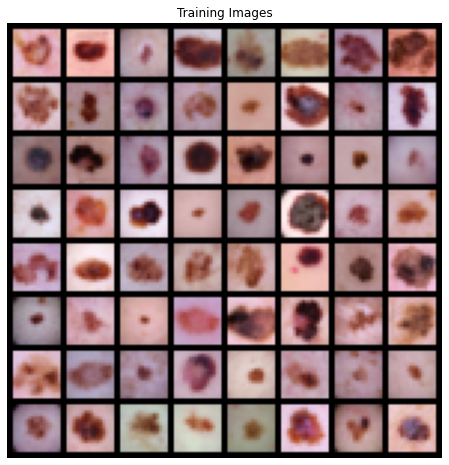

In [ ]:
#test
print("Phase1:")
phase1(netG, netD)
# unfreeze(netG.main)
# summary(netG.main, input_size=(nz, 1, 1),batch_size = batch_size)
num_epochs = 150
train(netG, netD, 16)

freeze(netG, netD)

In [ ]:
# debug_freeze(netG)
# debug_freeze(netD)

In [ ]:
# save_model(1,10,netG,netD,0.00)

Phase2:
Starting Training Loop...


RuntimeError: ignored

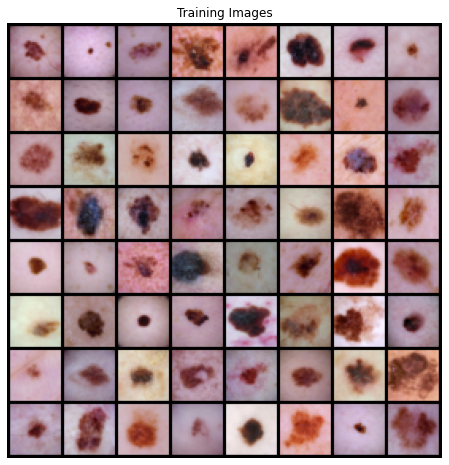

In [ ]:
#test
print("Phase2:")
phase2(netG, netD)
# unfreeze(netG.main)
# summary(netG.main, input_size=(nz, 1, 1),batch_size = batch_size)
num_epochs = 150
train(netG, netD, 32)

freeze(netG, netD)

In [ ]:
#test
print("Phase3:")
phase3(netG, netD)
# unfreeze(netG.main)
# summary(netG.main, input_size=(nz, 1, 1),batch_size = batch_size)
num_epochs = 200
train(netG, netD, 64)

# freeze(netG, netD)

In [ ]:
noise = torch.randn(1, nz, 1, 1, device=device)
fake = netG(noise).detach().cpu()
plt.imshow(np.transpose(fake[-1]))

In [ ]:
summary(netG.main, input_size=(nz, 1, 1),batch_size = batch_size)